In [2]:
import cv2
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10

In [0]:
sift = cv2.xfeatures2d.SIFT_create()
img1 = cv2.imread('building1.jpg', 0)
img2 = cv2.imread('building2.jpg', 0)
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
Show1 = cv2.drawKeypoints(img1, kp1,outImage = None, color=(0,255,0))
Show2 = cv2.drawKeypoints(img2, kp2,outImage = None, color=(0,255,0))

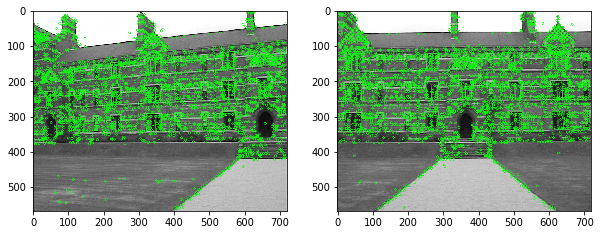

In [4]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Show1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(Show2)

[[624.4598999    6.90569496 340.84692383  20.89365196]
 [625.27593994  23.12547302 341.18591309  35.60541916]
 [607.52520752  25.17797089 324.82305908  14.16312027]
 ...
 [604.67950439 293.80081177 313.59832764 295.59909058]
 [417.21463013 302.74386597 129.78266907 302.0854187 ]
 [486.21496582 300.08120728 197.63201904 301.15402222]]


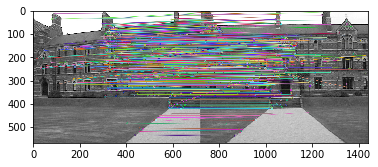

In [5]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
best_matches_to_show = []
best_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        best_matches_to_show.append([m])
        best_matches.append(m)
match_points = []
for match in best_matches:
  (x1, y1) = kp1[match.queryIdx].pt
  (x2, y2) = kp2[match.trainIdx].pt
  match_points.append([x1, y1, x2, y2])
match_points = np.matrix(match_points)
print(match_points)
draw_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,best_matches_to_show,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(draw_matches)

In [0]:
 def Homography_CAL(four_points):
    AList = []
    for point in four_points:
        x1 = point.item(0)
        y1 = point.item(1)
        x2 = point.item(2)
        y2 = point.item(3)
        a2 = [0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2]
        a1 = [-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2]
        AList.append(a1)
        AList.append(a2)
    Amatrix = np.matrix(AList)
    u, s, v = np.linalg.svd(Amatrix)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h

def Distance(match_point, h):
    p1 = np.transpose(np.matrix([match_point.item(0), match_point.item(1), 1]))
    ep2 = np.dot(h, p1)
    ep2 = (1/ep2.item(2))*ep2
    p2 = np.transpose(np.matrix([match_point.item(2), match_point.item(3), 1]))
    return np.linalg.norm(p2 - ep2)

In [7]:
MaxInliers = []
Hfinal = None
for i in range(700):
    four_rand = []
    p1 = np.array(match_points[random.randrange(0, len(match_points))])
    p2 =  np.array(match_points[random.randrange(0, len(match_points))])
    four_rand = np.concatenate((p1, p2), axis=0)
    p3 =  np.array(match_points[random.randrange(0, len(match_points))])
    four_rand = np.concatenate((four_rand, p3), axis=0)
    p4 =  np.array(match_points[random.randrange(0, len(match_points))])
    four_rand = np.concatenate((four_rand, p4), axis=0)
    h = Homography_CAL(four_rand)
    inliers = []
    for i in range(len(match_points)):
        dis = Distance(match_points[i][0], h)
        if dis < 5:
            inliers.append(match_points[i])
    if len(inliers) > len(MaxInliers):
        MaxInliers = inliers
        Hfinal = h
print("final homography matrix:")
print(Hfinal)
print("final inliers number:")
print(len(MaxInliers))

final homography matrix:
[[ 1.28428900e+00 -1.57172103e-02 -3.82366661e+02]
 [ 1.35921508e-01  1.19481817e+00 -6.84271579e+01]
 [ 3.82972394e-04 -1.08585262e-05  1.00000000e+00]]
final inliers number:
795


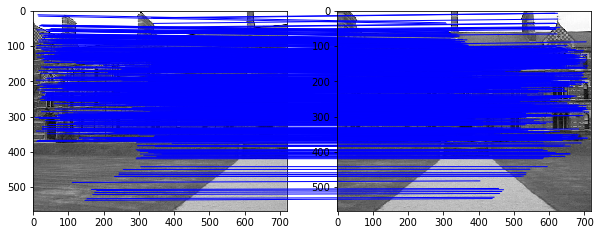

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 10)) 
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")
for points in MaxInliers:
  x1 = (points[0,0])
  y1 = (points[0,1])
  x2 = (points[0,2])
  y2 = (points[0,3])
  con = ConnectionPatch(xyA=(x1,y1),xyB=(x2,y2), coordsA="data", coordsB="data",axesA=ax2, axesB=ax1, color="blue")
  ax2.add_artist(con)
plt.show()

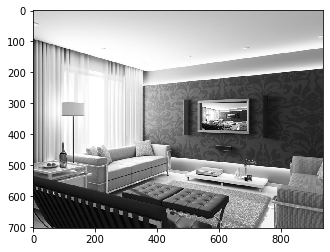

In [9]:
room = cv2.imread('room.jpg', 0)
p1 =  np.array([[0,0,300,545]])
p2 =  np.array([[0,935,300,690]])
randomPoints = np.concatenate((p1, p2), axis=0)
p3 =  np.array([[700,0,385,545]])
randomPoints = np.concatenate((randomPoints, p3), axis=0)
p4 =  np.array([[700,935,385,690]])
randomPoints = np.concatenate((randomPoints, p4), axis=0)
h = Homography_CAL(randomPoints)
for i in range (700):
  for j in range (935):
    p1 = np.transpose(np.matrix([i, j, 1]))
    ep2 = np.dot(h, p1)
    room[int(ep2[0])][int(ep2[1])] = room[i][j]
plt.imshow(room, cmap="gray")
plt.show()